In [1]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import os
import glob
import tqdm
import numpy as np
import pandas as pd
from timm.optim.adan import Adan
from timm.utils.model_ema import ModelEmaV2
from timm.scheduler.cosine_lr import CosineLRScheduler
from timm.loss.asymmetric_loss import AsymmetricLossMultiLabel

from accelerate import Accelerator
import albumentations as A
import audiomentations as Audio
from albumentations.pytorch import ToTensorV2

from utils import (
    util,
    modules,
    custom_dataset,
)

import gc
import sklearn.metrics

import timm
import matplotlib.pyplot as plt
import librosa

In [2]:
model = modules.ImageBindAudio(checkpoint_path=None)
model.load_state_dict("checkpoint/ConvNextS_model.pt")

<All keys matched successfully>


In [3]:
model.adapter

Parameter containing:
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True)

In [4]:
torch.set_float32_matmul_precision('high')
accelerator = Accelerator()
device = accelerator.device

# Parameters

In [5]:
MODEL_NAME = "ConvNextS"

id2cls = os.listdir("dataset/train_audio")
id2cls.sort()
cls2id = {v: k for k, v in enumerate(id2cls)}

LR = 2e-4
LR_MIN = 2e-5
EPOCHS = 200
VALID_EPOCH = 50
BATCH_SIZE = 1
NUM_WORKER = 0
WEIGHT_DECAY = 3e-4

valid_rate = .1
test_duration = 5
train_duration = 10
split_data_seed = 3407

MIN_SAMPLE = 30

cur_epoch = 0

In [6]:
audio_transform = Audio.Compose(
    [
        Audio.AirAbsorption(
            min_distance=5,
            max_distance=300,
            p=.5
        ),
        # Audio.AddBackgroundNoise(
        #     sounds_path=glob.glob("outside_dataset/audio/*.wav"),
        #     min_snr_in_db=3.0,
        #     max_snr_in_db=40.0,
        #     noise_transform=Audio.PolarityInversion(),
        #     p=.5
        # ),
        Audio.OneOf(
            [
                Audio.Gain(),
                Audio.GainTransition()
            ],
            p=.4
        ),
        Audio.AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.3),
        # 右边拉伸缩短
        Audio.TimeStretch(min_rate=0.8, max_rate=1.25, p=.5),
        # 上下移动
        # Audio.PitchShift(min_semitones=-6, max_semitones=6, p=.5),
        # 滚轮滑动
        Audio.Shift(min_fraction=-0.5, max_fraction=0.5, p=.5),
        # 时间轴 mask
        Audio.TimeMask(min_band_part=0.1, max_band_part=0.3, fade=True, p=.5),
        
        Audio.OneOf(
            [
                # 分贝普遍降低
                Audio.LowPassFilter(50, 5000,  p=.5),
                # 分贝普遍提高
                Audio.HighPassFilter(50, 2000, p=.5),
                # 分贝随机高低
                Audio.BandPassFilter(50, 2000, p=.5),
                Audio.BandStopFilter(p=.5)
            ],
            p=.4
        ),
    ]
)

spec_transofrm = Audio.SpecFrequencyMask(p=.5)

train_transform = A.Compose([
    # A.Resize(128, 312),
    A.Resize(128, 204),
    ToTensorV2(),
])
test_transform = A.Compose([
    A.Resize(128, 312),
    ToTensorV2(),
])

ValueError: min_band_part must not be greater than max_band_part

# Dataset

In [7]:
data = pd.read_csv("dataset/time_audio.csv")
train_idx, valid_idx = custom_dataset.split_data(data, valid_rate, split_data_seed)
train_data = data.loc[train_idx].reset_index(drop=True)
train_data = custom_dataset.upsample_data(train_data, MIN_SAMPLE)
valid_data = data.loc[valid_idx].reset_index(drop=True)
valid_data = pd.concat([valid_data, valid_data, valid_data, valid_data, valid_data], axis=0, ignore_index=True)


def collate_fn(batch):
    x = torch.stack([b[0] for b in batch])
    y = [b[1] for b in batch]
    
    return x, y

In [8]:
train_dataloader = torch.utils.data.DataLoader(
    custom_dataset.CustomDatset(
        train_data,
        cls2id=cls2id,
        root="dataset/train_audio/",
        duration=train_duration,
        transform=train_transform,
        audio_transform=audio_transform,
        spec_transofrm=spec_transofrm,
        train_mode=True,
    ),
    collate_fn=collate_fn,
    batch_size=BATCH_SIZE,
    pin_memory=False,
    shuffle=True,
    num_workers=NUM_WORKER,
)

valid_dataloader = torch.utils.data.DataLoader(
    custom_dataset.CustomDatset(
        valid_data,
        cls2id=cls2id,
        root="dataset/train_audio/",
        duration=test_duration,
        transform=test_transform,
        train_mode=False
    ),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKER,
)

del data, train_data, valid_data, train_idx, valid_idx
gc.collect()

In [31]:
imgs, label = next(iter(train_dataloader))
# imgs, label = next(iter(valid_dataloader))

([131, 124], torch.Size([128, 204]))

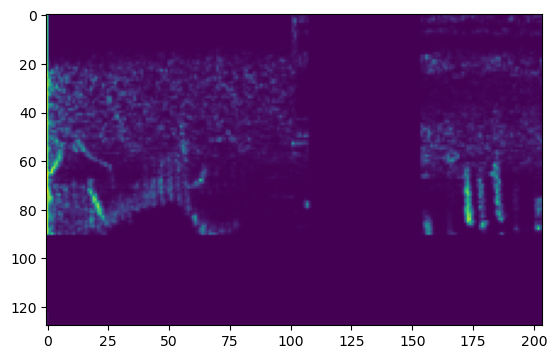

In [32]:
idx = 0
x = imgs[idx][0]
y = label[idx]
plt.imshow(x)
y, x.shape


# Model

In [ ]:
model = modules.ConvNext(len(id2cls), pretrained=True, dropout=0.)
ema_model = ModelEmaV2(model, decay=.9999, device=device)

# Misc

In [ ]:
# class Criterion(nn.BCEWithLogitsLoss):
#     def __init__(self, **kwargs):
#         super().__init__(**kwargs)
#         self.reduction = "none"
        
#     def forward(self, x, y):
#         b = x.shape[0]
#         m = torch.zeros_like(x, device=device)
#         for i in range(b):
#             m[i, y[i]] = 1.
#         loss = super().forward(x, m).sum(dim=1).mean()
        
#         return loss
    
# class Criterion(AsymmetricLossMultiLabel):
#     def forward(self, x, y):
#         b = x.shape[0]
#         m = torch.zeros_like(x, device=device)
#         for i in range(b):
#             m[i, y[i]] = 1.
            
#         return super().forward(x, m)

class Criterion(nn.MultiLabelSoftMarginLoss):
    def forward(self, x, y):
        b = x.shape[0]
        m = torch.zeros_like(x, device=device)
        for i in range(b):
            m[i, y[i]] = 1.
            
        return super().forward(x, m)

criterion = Criterion()
optimizer = Adan(
    util.get_param_groups(model, ("norm",)),
    lr=LR,
    weight_decay=WEIGHT_DECAY,
)
# lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
#     optimizer,
#     EPOCHS // 2,
#     eta_min=1e-8
# )
lr_scheduler = CosineLRScheduler(
    optimizer,
    EPOCHS,
    warmup_lr_init=LR_MIN,
    warmup_t=EPOCHS // 6,
)

In [ ]:
model, optimizer, train_dataloader, valid_dataloader, lr_scheduler = accelerator.prepare(
    model, 
    optimizer,
    train_dataloader,
    valid_dataloader,
    lr_scheduler
)

# Train

In [ ]:
def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    dataloader = tqdm.tqdm(dataloader, disable=not accelerator.is_local_main_process)
    
    losses = 0
    for i, (x, y) in enumerate(dataloader, 1):
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        losses += loss.item()
        
        accelerator.backward(loss)
        optimizer.step()
        ema_model.update(model)
    
    return losses / len(dataloader)

@torch.no_grad()
def valid_one_epoch(model, dataloader):
    def padded_cmap(submission, solution, padding_factor=5):
        b, c = solution.shape
        new_rows = np.ones((padding_factor, c))
        padded_solution = np.concatenate((solution, new_rows), axis=0)
        padded_submission = np.concatenate((submission, new_rows), axis=0)
        score = sklearn.metrics.average_precision_score(
            padded_solution,
            padded_submission,
            average='macro',
        )
        
        return score
    
    model.eval()
    dataloader = tqdm.tqdm(dataloader, disable=not accelerator.is_local_main_process)
    
    output = []
    target = []
    for x, y in dataloader:
        if y.dim() == 1:
            y = y.reshape(-1, 1)
        out = model(x).cpu()
        output.append(out.sigmoid())
        target.append(torch.zeros_like(out).scatter(1, y.cpu(), 1.))
        
    score = padded_cmap(
        torch.cat(output).numpy(),
        torch.cat(target).numpy(),
        1
    )
    
    return score * 100

In [ ]:
min_loss = float("inf")
max_score = 0
for epoch in range(cur_epoch, EPOCHS + 1):
    loss = train_one_epoch(model, train_dataloader, optimizer, criterion)
    accelerator.wait_for_everyone()
    lr_scheduler.step(epoch)
    accelerator.print(f"Epoch {epoch} - Loss: {loss :.4f}\tlr: {optimizer.param_groups[0]['lr']*1e4 :.4f}")
    if min_loss > loss:
        min_loss = loss
    if epoch == int(EPOCHS // 6):
        util.update_dropout_rate(model, .3)
    torch.save(
        {
            "model": accelerator.unwrap_model(model).state_dict(),
            "lr_scheduler": lr_scheduler.state_dict(),
            "epoch": epoch,
        },
        f"checkpoint/{MODEL_NAME}_all.pt"
    )
    
    torch.save(
        {
            "model": accelerator.unwrap_model(model).state_dict(),
            "ema": ema_model.module.state_dict()
        },
        f"checkpoint/{MODEL_NAME}_model.pt"
    )
    if epoch % VALID_EPOCH == 0:
        s = valid_one_epoch(model, valid_dataloader)
        if s > max_score:
            torch.save(
                {
                    "model": accelerator.unwrap_model(model).state_dict(),
                    "ema": ema_model.module.state_dict()
                },
                f"checkpoint/{MODEL_NAME}_best.pt"
            )
        max_score = max(s, max_score)
        accelerator.print(f"Valid Epoch {epoch} - Score: {s :.2f}%\tMax Score: {max_score :.2f}%")